# Postmating response in axenic and control _D. melanogaster_ females

Load packages and functions:

In [1]:
## Packages to load
req_packages = c("Biobase", "cluster", "cowplot", 
                 "data.table", "edgeR", "ggpubr", 
                 "ggrepel", "ggthemes", "ggthemr", "Glimma", 
                 "GO.db", "goseq", "gplots", "grid", "gridExtra", "lattice", 
                 "imager", "pheatmap", "qvalue", "RColorBrewer", 
                 "reshape", "Rmisc", "splitstackshape", "statmod", "stringr", "tidyverse",
                 "VennDiagram", "viridis")
## load them, quietly
invisible(suppressWarnings(suppressMessages(lapply(req_packages, require, character.only = TRUE))))

## The Cowplot package changes the default themes of ggplot2. Set the bw theme with larger font sizes like so:
# theme_set(theme_bw(base_size = 16))
## ... or set the default theme
theme_set(theme_gray())

## suppress excessive VennDiagram log files
futile.logger::flog.threshold(futile.logger::ERROR, name = "VennDiagramLogger")

NULL

Load custom functions:

In [2]:
source("Functions.R")

Some raw files need to be processed to produce auxiliary files needed below. Running a script in the "Misc" folder should do it:

In [3]:
# system('./Misc/initial_file_modifications.sh')

Load the modENCODE expression atlas:

In [4]:
mel_modENCODE = read.csv("Annotoations/gene_rpkm_report_fb_2018_02.tsv", header = T, sep = "\t")

Load read count data:

In [5]:
counts_bt2 = read.table("eXpress/express.gene.counts.matrix", header=T, row.names=1, com='', check.names=F)

Load annotation files:

In [6]:
annotation = read.csv("Annotoations/fbgn_annotation_ID_fb_2018_04_mod.tsv", header = T, check.names = F, sep ="\t")

Load the gene snapshot data:

In [7]:
snapshots = read.csv("Annotoations/gene_snapshots_fb_2018_05.tsv", header = T, sep ="\t", quote = "")

Load the transcript lengths for the eXpress data:

In [8]:
bt2_trans_lengths = read.csv("eXpress/transcriptome/transcript_lengths.txt", header = T, sep = "\t")

Load the gene-to-transcript mapping:

In [9]:
gene_trans_map = read.table("eXpress/transcriptome/dmel-all-transcript-r6.23.gene_trans_map", header = F, sep = "\t")
colnames(gene_trans_map) = c("gene_id", "transcript_id")

Generate a gene length object for the eXpress data:

In [10]:
# Merge transcript length file with gene-to-trans file:
tmpMrge = merge(bt2_trans_lengths, gene_trans_map)
# Select only the length and gene_id columns
tmpMrge = as.data.table(subset(tmpMrge, select = c("length", "gene_id")))
# For each gene ID entry, select the entry with largest value in the "length" column:
bt2_gene_lengths = tmpMrge[tmpMrge[, .I[which.max(length)], by=gene_id]$V1]
# remove un-needed intermediate objects
rm(tmpMrge)

Generate sample info object:

In [11]:
sampleData = read.table("Misc/samples.txt", header = F, check.names = F, fill = T)
sampleInfo = sampleData
colnames(sampleInfo) = c("Sample", "Replicate")

sampleInfo$Female = ifelse(grepl("^A",sampleInfo$Sample), "axenic", "control")

sampleInfo$Male = ifelse(grepl("A$", sampleInfo$Sample), "axenic", ifelse(grepl("C$", sampleInfo$Sample), "control", "none"))

sampleInfo$Handler = ifelse(grepl("3|4", sampleInfo$Replicate), "Yasir", "Sofie")

sampleInfo$Status = ifelse(grepl("none", sampleInfo$Male), "virgin", "mated")

Generate a TPM table from the counts. Use any arbitrary number for lengths since this is 3prime data:

In [12]:
tpm_bt2 <- apply(counts_bt2, 2, function(x) tpm(x, 2000))

Reshape the TPM matrix to calculate means and generate heatmaps and individual gene plots later:

In [13]:
tmp.tpmMatrix<-tpm_bt2
# colnames(tmp.tpmMatrix) <- sampleInfo$Sample
tmp.tpmMatrix.m <- as.data.frame(melt(as.matrix(tmp.tpmMatrix)))
colnames(tmp.tpmMatrix.m) <- c("gene_id", "replicate", "TPM")
tmp.tpmMatrix.m <- merge(tmp.tpmMatrix.m, sampleInfo, by.x = "replicate", by.y = "Replicate", all.x = T)
tmp.tpmMatrix.m$replicate = gsub(".*_", "", tmp.tpmMatrix.m$replicate)
annot.sub = subset(annotation, select = c("primary_FBgn", "gene_symbol", "annotation_ID"))
tmp.tpmMatrix.m = merge(tmp.tpmMatrix.m, annot.sub, by.x = "gene_id", by.y = "primary_FBgn", all.x = T)
# tmp.tpmMatrix.m = merge
tpm.table = tmp.tpmMatrix.m
tpm.table$Male = factor(tpm.table$Male, levels = c("none", "axenic", "control"))
tpm.table$Status = factor(tpm.table$Status, levels = c("virgin", "mated"))
rm(tmp.tpmMatrix.m)

the `geneBoxPlot` function can be used for single gene tpm boxplots of the data:

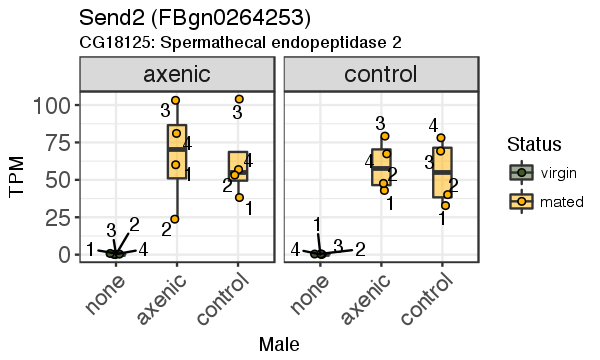

In [14]:
options(repr.plot.width = 5, repr.plot.height = 3)
geneBoxPlot("Send2", show_reps = T)

Output library size object:

In [15]:
LibSizes <- as.data.frame(colSums(counts_bt2))
libSizes <- cbind(sample = row.names(LibSizes), LibSizes)
row.names(libSizes)<- NULL
colnames(libSizes) = c("replicate", "counts")
libSizes$sample = gsub("_.*", "", libSizes$replicate)

Make a barplot of library sizes:

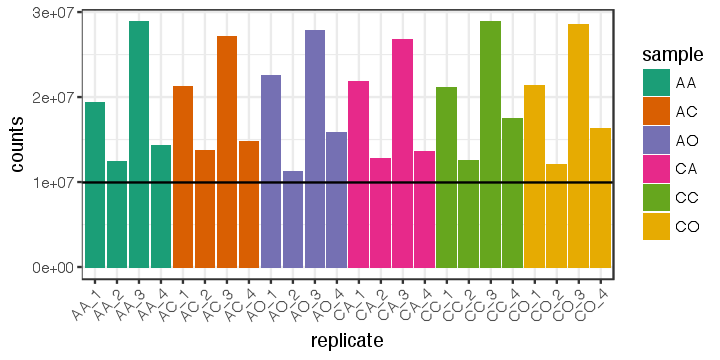

In [16]:
options(repr.plot.width = 6, repr.plot.height = 3)
# pdf("Figures/Library_sizes.pdf", width = 12, height = 4)
ggplot(libSizes, aes(replicate, counts, fill = sample)) + 
    geom_bar(stat="identity", position = "dodge") + 
    theme_bw() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
    geom_hline(yintercept = 10000000) +
    scale_fill_brewer(palette="Dark2") 
# dev.off()

### Differential expression analysis (eXpress):

First, filter out genes with very low expression from the counts matrix. We'll use a minimum cutoff of 1 CPM in at least 4 samples:

In [17]:
# counts_bt2 = subset(counts_bt2, rownames(counts_bt2) %!in% wierd_genes)
cpm_bt2 <- cpm(counts_bt2)
thresh_bt2 <- cpm_bt2 > 1
keep_bt2 <- rowSums(thresh_bt2) >= 4
countsKeep_bt2 <- counts_bt2[keep_bt2,]
# countsKeep_bt2 <- subset(countsKeep_bt2, rownames(countsKeep_bt2) %!in% wierd_genes)
dim(countsKeep_bt2)

[1] 7649   24

Now define the groupings by sample and set up the design matrix:

In [18]:
groups = factor(sampleInfo$Sample)
design = model.matrix( ~ 0 + groups)
colnames(design) <- levels(groups)
rownames(design) <- sampleInfo$Replicate

Create the DGElist object and GLM fit:

In [19]:
dgeList <- DGEList(counts = countsKeep_bt2, group = groups)
dgeList <- calcNormFactors(dgeList)
dgeList <- estimateCommonDisp(dgeList)
dgeList <- estimateTagwiseDisp(dgeList)
dgeList_fit <- glmFit(dgeList, design)
summary(dgeList$tagwise.dispersion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02658 0.05811 0.07449 0.13260 0.12080 3.49400 

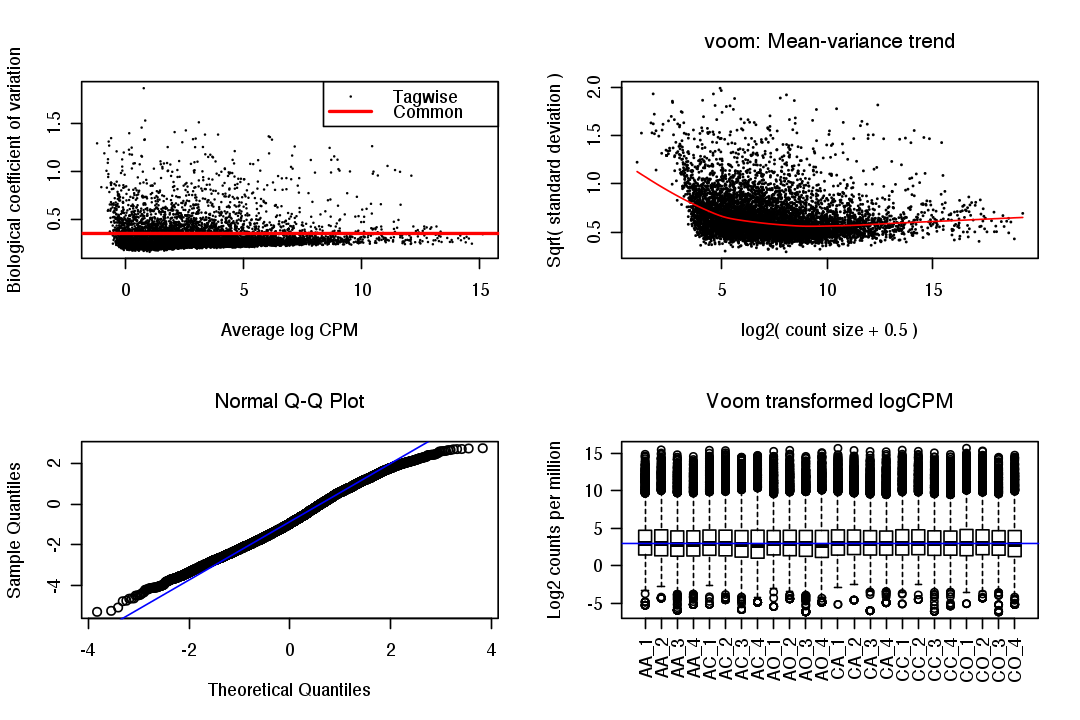

In [20]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList)
# mean-variance trend
virgin.voom = voom(dgeList, design, plot=TRUE)
# QQ-plot
g.v <- gof(dgeList_fit)
z.v <- zscoreGamma(g.v$gof.statistics,shape=g.v$df/2,scale=2)
qqnorm(z.v); qqline(z.v, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(virgin.voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(virgin.voom$E),col="blue")

rm(virgin.voom, g.v, z.v)


Generate a correlation plot between replicates:

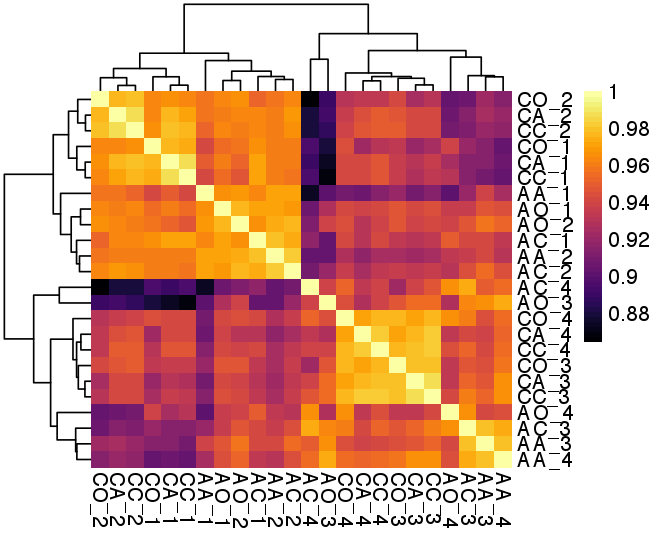

In [21]:
## Plot sample correlation
data = log2(countsKeep_bt2+1)
# colnames(data) = gsub("Female_", "", colnames(data))
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')

options(repr.plot.width = 5.5, repr.plot.height = 4.5)
pheatmap(
  mat               = sample_cor,
  color             = inferno(50),
  border_color      = NA,
  show_colnames     = TRUE,
  show_rownames     = TRUE,
#   filename          = "Figures/repTract_sample_correlations.pdf",
#   width             = 6, 
#   height            = 5,
  fontsize          = 12    
)
rm(data)
rm(sample_cor)

Hmmmm.... wierd groupings by replicate. Look at an MDS plot:

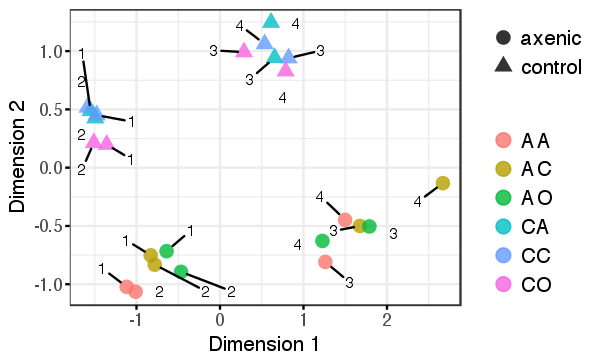

In [22]:
options(repr.plot.width = 5, repr.plot.height = 3)
c.mds.gg(dgeList)

Something funny is going on with replicate grouping. First we'll explore the results without doing anything about the replicates. 

Before running the likelihood ration tests, we'll make an FBgn-to-gene symbol object to append to the tTags tables:

In [23]:
FBgn_to_symbol = subset(annotation, select = c("gene_symbol", "primary_FBgn"))

We'll also set up all the relevant contrasts:

In [24]:
virgin_contrasts <- makeContrasts(CO-AO, levels=design)
AA.v.AO_contrasts <- makeContrasts(AA-AO, levels=design)
AC.v.AO_contrasts <- makeContrasts(AC-AO, levels=design)
CA.v.CO_contrasts <- makeContrasts(CA-CO, levels=design)
CC.v.CO_contrasts <- makeContrasts(CC-CO, levels=design)

First look at the difference between the axenic and control virgin samples:

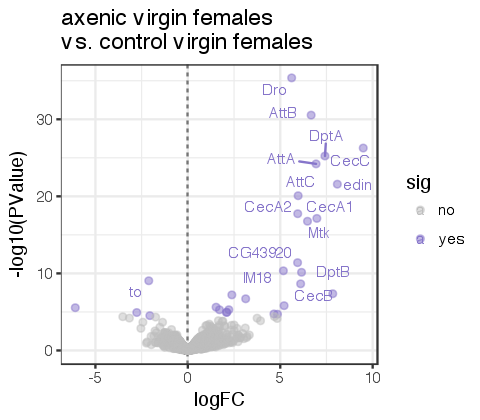

In [25]:
# run the LRT and extract the DE table
lrt.virgins.table <- edge.DE(dgeList_fit, virgin_contrasts)
virgins_sigGenes = subset(lrt.virgins.table, sig == "yes")$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
# pdf("Figures/virgin_female_contrast.pdf", width = 4, height = 3.5)
(virgin_contrasts_volcano.gg = edge.DE.gg(lrt.virgins.table) +
                                scale_colour_manual(values = c("gray","#8675ca")) +
                                geom_text_repel(data = filter(lrt.virgins.table, sig == "yes" & -log10(PValue) > 7.5),aes(label=gene_symbol), 
                                force = 10,
                                fontface = "bold", 
                                size = 3) +
                                labs(title = "axenic virgin females \nvs. control virgin females", size = 2))
# dev.off()

Output individual gene plots:

In [26]:
virgins_sigGenes.Plots = suppressMessages(lapply(virgins_sigGenes, geneBoxPlot))
ggsave("Figures/virgins_sigGenes.Plots.pdf", marrangeGrob(grobs = virgins_sigGenes.Plots, nrow = 2, ncol =2))

Saving 7 x 7 in image


And output snapshot summary:

In [27]:
tempInfo = filter(snapshots, FBgn_ID %in% virgins_sigGenes)
tempInfo = select(tempInfo, -datestamp)
write.table(tempInfo, "Results/virgins_sigGenes.txt", quote = F, sep = "\t", row.names = F)

Now compare the mated axenic females to virgin axenic females. First, females mated to axenic males

In [28]:
# run the LRT and extract the DE table
lrt.AA.v.AO.table <- edge.DE(dgeList_fit, AA.v.AO_contrasts)
AA.v.AO_sigGenes = subset(lrt.AA.v.AO.table, sig == "yes")$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
AA.v.AO_contrasts_volcano.gg = edge.DE.gg(lrt.AA.v.AO.table) +
                                scale_colour_manual(values = c("gray","#007954")) +
                                geom_text_repel(data = filter(lrt.AA.v.AO.table, sig == "yes" & -log10(PValue) > 7.5),aes(label=gene_symbol), 
                                force = 10,
                                fontface = "bold", 
                                size = 3) +
                                labs(title = "axenic females X axenic males\nvs. axenic virgin females", size = 2)

... and females mated to control males

In [29]:
# run the LRT and extract the DE table
lrt.AC.v.AO.table <- edge.DE(dgeList_fit, AC.v.AO_contrasts)
AC.v.AO_sigGenes = subset(lrt.AC.v.AO.table, sig == "yes")$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
AC.v.AO_contrasts_volcano.gg = edge.DE.gg(lrt.AC.v.AO.table) +
                                scale_colour_manual(values = c("gray","#007954")) +
                                geom_text_repel(data = filter(lrt.AC.v.AO.table, sig == "yes" & -log10(PValue) > 7.5),aes(label=gene_symbol), 
                                force = 10,
                                fontface = "bold", 
                                size = 3) +
                                labs(title = "axenic females X control males\nvs. axenic virgin females", size = 2)

Show those volcano plots:

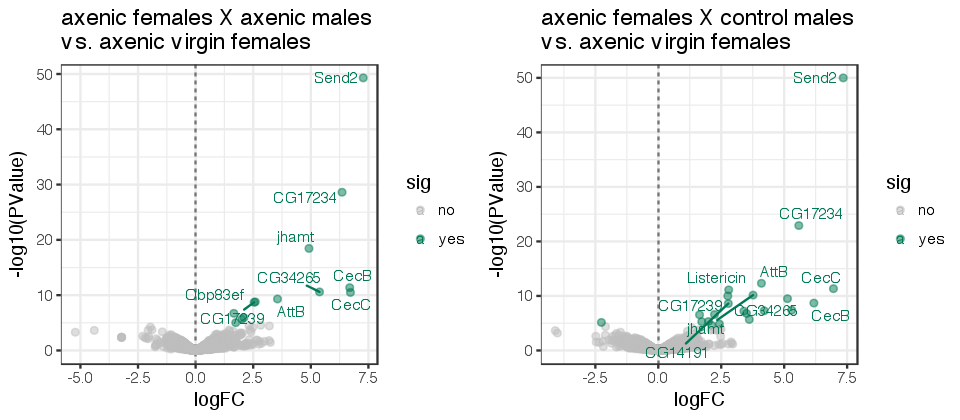

In [30]:
options(repr.plot.width = 8, repr.plot.height = 3.5)
# pdf("Figures/mated_axenic_female_contrasts.pdf", width = 8, height = 3.5)
plot_grid(AA.v.AO_contrasts_volcano.gg, AC.v.AO_contrasts_volcano.gg, ncol = 2)
# dev.off()

Now let's look at the control females. First, females mated to axenic males

In [31]:
# run the LRT and extract the DE table
lrt.CA.v.CO.table <- edge.DE(dgeList_fit, CA.v.CO_contrasts)
CA.v.CO_sigGenes = subset(lrt.CA.v.CO.table, sig == "yes")$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
CA.v.CO_contrasts_volcano.gg = edge.DE.gg(lrt.CA.v.CO.table) +
                                scale_colour_manual(values = c("gray","#c9578c")) +
                                geom_text_repel(data = filter(lrt.CA.v.CO.table, sig == "yes" & -log10(PValue) > 7.5),aes(label=gene_symbol), 
                                force = 10,
                                fontface = "bold", 
                                size = 3) +
                                labs(title = "control females X axenic males\nvs. control virgin females", size = 2)

... and females mated to control males

In [32]:
# run the LRT and extract the DE table
lrt.CC.v.CO.table <- edge.DE(dgeList_fit, CC.v.CO_contrasts)
CC.v.CO_sigGenes = subset(lrt.CC.v.CO.table, sig == "yes")$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
CC.v.CO_contrasts_volcano.gg = edge.DE.gg(lrt.CC.v.CO.table) +
                                scale_colour_manual(values = c("gray","#c9578c")) +
                                geom_text_repel(data = filter(lrt.CC.v.CO.table, sig == "yes" & -log10(PValue) > 7.5),aes(label=gene_symbol), 
                                force = 10,
                                fontface = "bold", 
                                size = 3) +
                                labs(title = "control females X control males\nvs. control virgin females", size = 2)

Show those volcano plots:

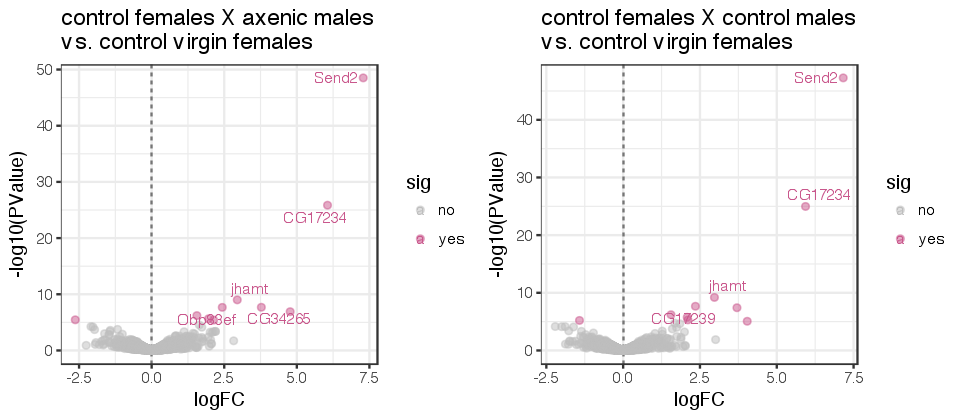

In [33]:
options(repr.plot.width = 8, repr.plot.height = 3.5)
# pdf("Figures/mated_control_female_contrasts.pdf", width = 8, height = 3.5)
plot_grid(CA.v.CO_contrasts_volcano.gg, CC.v.CO_contrasts_volcano.gg, ncol = 2)
# dev.off()

Let's make a point plot comparing the log fold-change between axenic and control females after mating to control males:

In [34]:
options(repr.plot.width = 4, repr.plot.height = 3.5)
AC.v.AO_x_CC.v.CO = diag.plot(lrt.AC.v.AO.table, lrt.CC.v.CO.table)
AA.v.AO_x_CA.v.CO = diag.plot(lrt.AA.v.AO.table, lrt.CA.v.CO.table)
AA.v.AO_x_AC.v.AO = diag.plot(lrt.AA.v.AO.table, lrt.AC.v.AO.table)
CC.v.CO_x_CA.v.CO = diag.plot(lrt.CC.v.CO.table, lrt.CA.v.CO.table)

Now output all these plots:

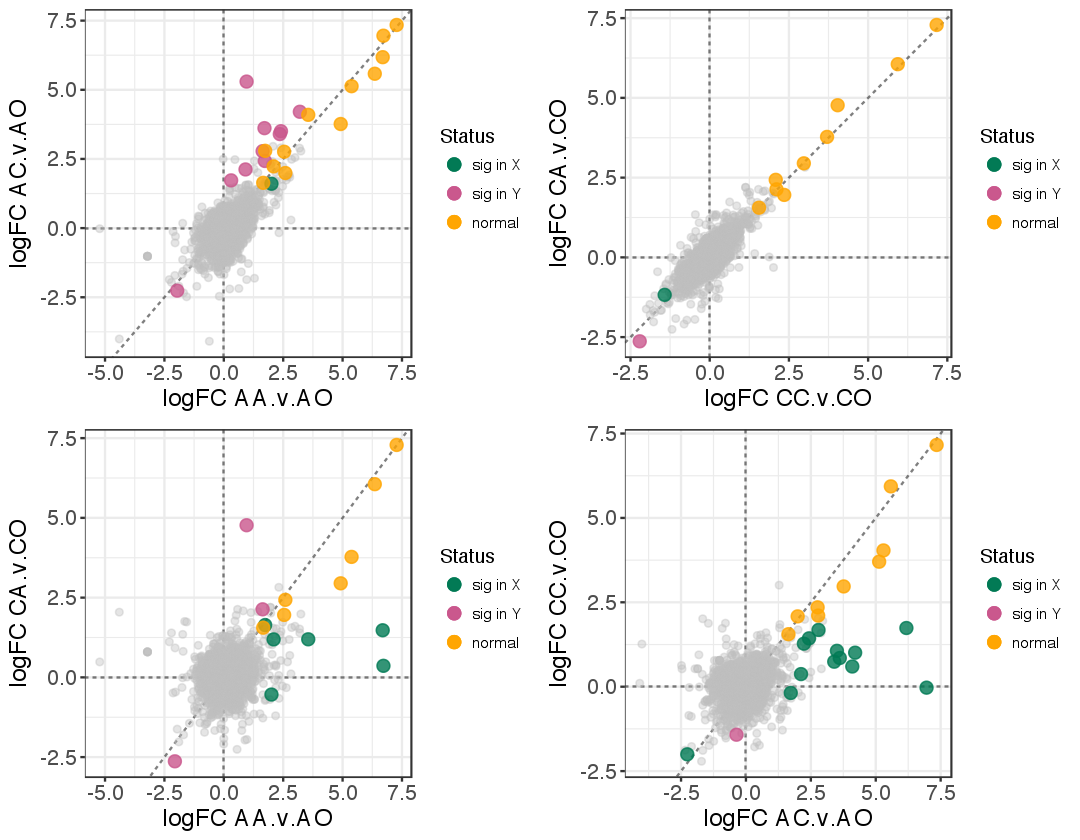

In [35]:
options(repr.plot.width = 9, repr.plot.height = 7)
# pdf("Figures/logFC_pointPlots_allReps.pdf", width = 9, height = 7)
plot_grid(AA.v.AO_x_AC.v.AO, CC.v.CO_x_CA.v.CO, AA.v.AO_x_CA.v.CO, AC.v.AO_x_CC.v.CO, ncol = 2)
# dev.off()

### Re-analysis with only replicates 1 and 2:

First, filter out genes with very low expression from the counts matrix. We'll use a minimum cutoff of 1 CPM in at least 4 samples:

In [36]:
counts_bt2_reps.1.2 = select(counts_bt2, matches("1|2"))
cpm_bt2_reps.1.2 <- cpm(counts_bt2_reps.1.2)
thresh_bt2_reps.1.2 <- cpm_bt2_reps.1.2 > 1
keep_bt2_reps.1.2 <- rowSums(thresh_bt2_reps.1.2) >= 2
countsKeep_bt2_reps.1.2 <- counts_bt2_reps.1.2[keep_bt2_reps.1.2,]
# countsKeep_bt2 <- subset(countsKeep_bt2, rownames(countsKeep_bt2) %!in% wierd_genes)
dim(countsKeep_bt2_reps.1.2)

[1] 7507   12

Now define the groupings by sample and set up the design matrix:

In [37]:
sampleInfo_reps.1.2 = filter(sampleInfo, Handler == "Sofie")
groups_reps.1.2 = factor(sampleInfo_reps.1.2$Sample)
design_reps.1.2 = model.matrix( ~ 0 + groups_reps.1.2)
colnames(design_reps.1.2) <- levels(groups_reps.1.2)
rownames(design_reps.1.2) <- sampleInfo_reps.1.2$Replicate

Create the DGElist object and GLM fit:

In [38]:
dgeList_reps.1.2 <- DGEList(counts = countsKeep_bt2_reps.1.2, group = groups_reps.1.2)
dgeList_reps.1.2 <- calcNormFactors(dgeList_reps.1.2)
dgeList_reps.1.2 <- estimateCommonDisp(dgeList_reps.1.2)
dgeList_reps.1.2 <- estimateTagwiseDisp(dgeList_reps.1.2)
dgeList_reps.1.2_fit <- glmFit(dgeList_reps.1.2, design_reps.1.2)
summary(dgeList_reps.1.2$tagwise.dispersion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02477 0.04285 0.05107 0.06368 0.06607 1.62400 

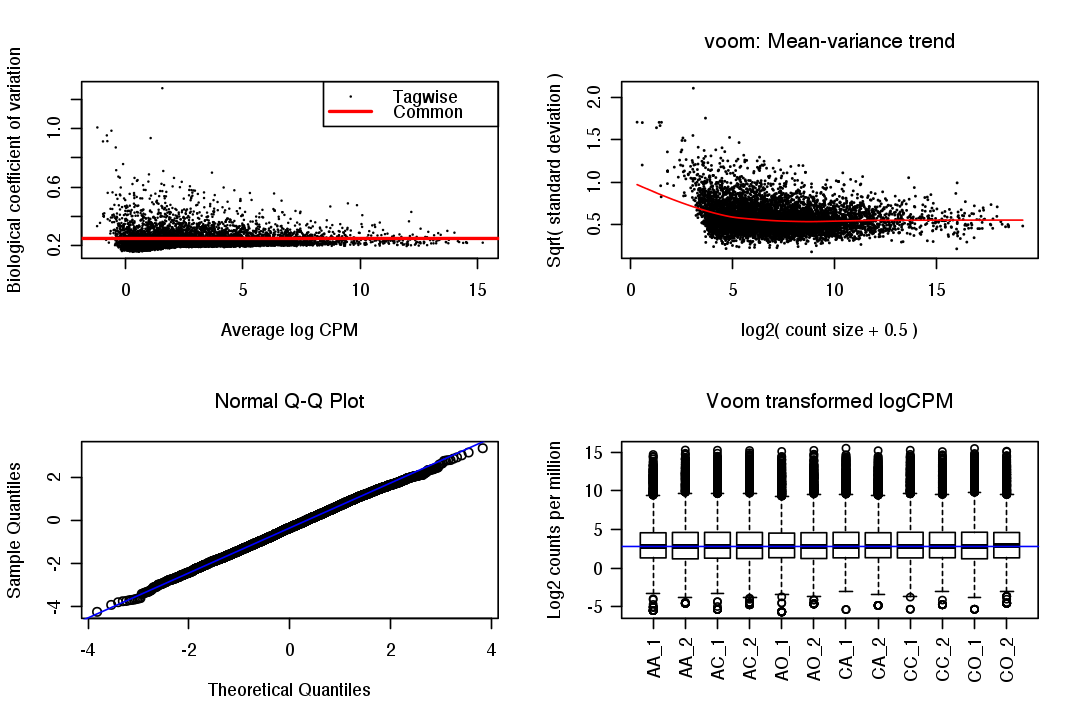

In [39]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList_reps.1.2)
# mean-variance trend
virgin.voom = voom(dgeList_reps.1.2, design_reps.1.2, plot=TRUE)
# QQ-plot
g.v <- gof(dgeList_reps.1.2_fit)
z.v <- zscoreGamma(g.v$gof.statistics,shape=g.v$df/2,scale=2)
qqnorm(z.v); qqline(z.v, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(virgin.voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(virgin.voom$E),col="blue")

rm(virgin.voom, g.v, z.v)

Generate a correlation plot between replicates:

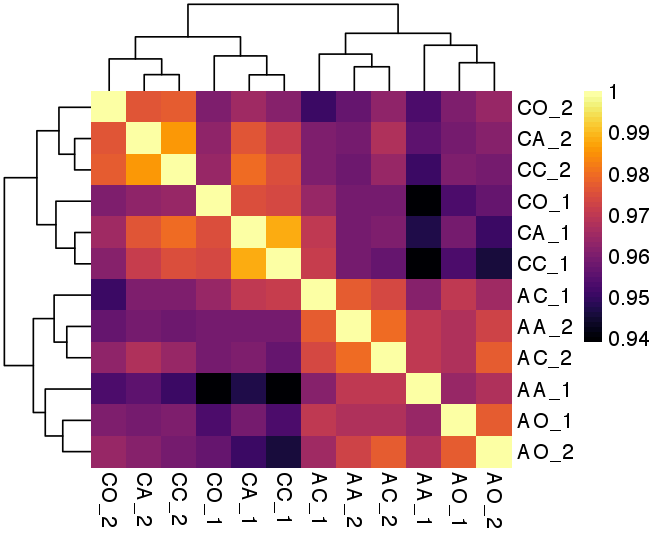

In [40]:
## Plot sample correlation
data = log2(countsKeep_bt2_reps.1.2+1)
# colnames(data) = gsub("Female_", "", colnames(data))
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')

options(repr.plot.width = 5.5, repr.plot.height = 4.5)
pheatmap(
  mat               = sample_cor,
  color             = inferno(50),
  border_color      = NA,
  show_colnames     = TRUE,
  show_rownames     = TRUE,
#   filename          = "Figures/repTract_sample_correlations.pdf",
#   width             = 6, 
#   height            = 5,
  fontsize          = 12    
)
rm(data)
rm(sample_cor)

Look at an MDS plot:

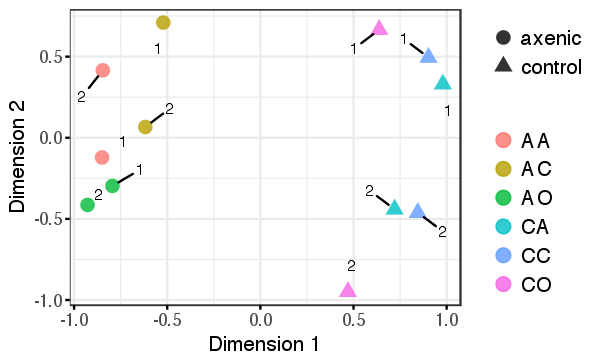

In [41]:
options(repr.plot.width = 5, repr.plot.height = 3)
c.mds.gg(dgeList_reps.1.2)

First look at the difference between the axenic and control virgin samples:

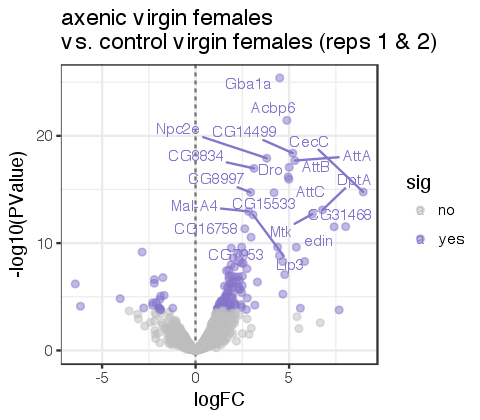

In [42]:
# run the LRT and extract the DE table
lrt.virgins_reps.1.2.table <- edge.DE(dgeList_reps.1.2_fit, virgin_contrasts)
virgins_reps.1.2_sigGenes = subset(lrt.virgins_reps.1.2.table, sig == "yes")$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
# pdf("Figures/virgin_female_contrast_reps.1.2.pdf", width = 4, height = 3.5)
(virgin_reps.1.2_contrasts_volcano.gg = edge.DE.gg(lrt.virgins_reps.1.2.table) +
                                scale_colour_manual(values = c("gray","#8675ca")) +
                                geom_text_repel(data = filter(lrt.virgins_reps.1.2.table, sig == "yes" & -log10(PValue) > 10),aes(label=gene_symbol), 
                                force = 10,
                                fontface = "bold", 
                                size = 3) +
                                labs(title = "axenic virgin females \nvs. control virgin females (reps 1 & 2)", size = 2))
# dev.off()

Now compare the mated axenic females to virgin axenic females. First, females mated to axenic males

In [43]:
# run the LRT and extract the DE table
lrt.AA.v.AO_reps.1.2.table <- edge.DE(dgeList_reps.1.2_fit, AA.v.AO_contrasts)
AA.v.AO_reps.1.2_sigGenes = subset(lrt.AA.v.AO_reps.1.2.table, sig == "yes")$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
AA.v.AO_reps.1.2_contrasts_volcano.gg = edge.DE.gg(lrt.AA.v.AO_reps.1.2.table) +
                                scale_colour_manual(values = c("gray","#007954")) +
                                geom_text_repel(data = filter(lrt.AA.v.AO_reps.1.2.table, sig == "yes" & -log10(PValue) > 10),
                                                aes(label=gene_symbol),
                                                force = 10,
                                                fontface = "bold",
                                                size = 3) +
                                labs(title = "axenic females X axenic males\nvs. axenic virgin females (reps 1 & 2)", size = 2)

... and females mated to control males

In [44]:
# run the LRT and extract the DE table
lrt.AC.v.AO_reps.1.2.table <- edge.DE(dgeList_reps.1.2_fit, AC.v.AO_contrasts)
AC.v.AO_reps.1.2_sigGenes = subset(lrt.AC.v.AO_reps.1.2.table, sig == "yes")$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
AC.v.AO_reps.1.2_contrasts_volcano.gg = edge.DE.gg(lrt.AC.v.AO_reps.1.2.table) +
                                scale_colour_manual(values = c("gray","#007954")) +
                                geom_text_repel(data = filter(lrt.AC.v.AO_reps.1.2.table, sig == "yes" & -log10(PValue) > 10),
                                                aes(label=gene_symbol),
                                                force = 10,
                                                fontface = "bold",
                                                size = 3) +
                                labs(title = "axenic females X control males\nvs. axenic virgin females (reps 1 & 2)", size = 2)

Show those volcano plots:

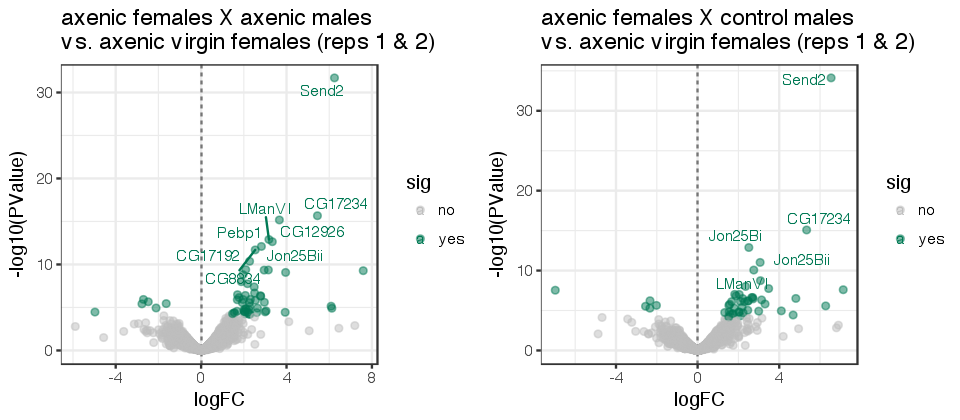

In [45]:
options(repr.plot.width = 8, repr.plot.height = 3.5)
# pdf("Figures/mated_axenic_female_contrast_reps.1.2.pdf", width = 8, height = 3.5)
plot_grid(AA.v.AO_reps.1.2_contrasts_volcano.gg, AC.v.AO_reps.1.2_contrasts_volcano.gg, ncol = 2)
# dev.off()

Lots more upregulated genes in this case compared to the useof all replicates. Let's look at an example gene from this list:

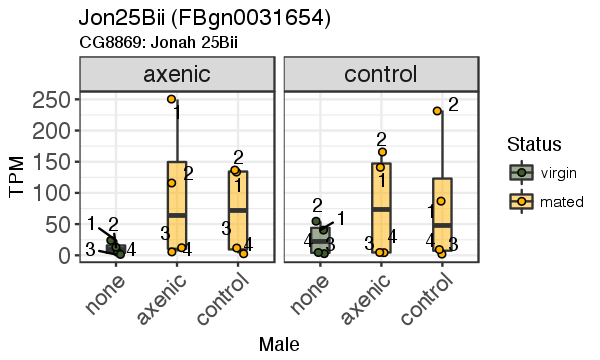

In [46]:
options(repr.plot.width = 5, repr.plot.height = 3)
geneBoxPlot("Jon25Bii", show_reps = T)

Looks like patterns can be driven by the erroneous behaviour of the two replicate groupings.

Now let's look at the control females.

First, females mated to axenic males

In [47]:
# run the LRT and extract the DE table
lrt.CA.v.CO_reps.1.2.table <- edge.DE(dgeList_reps.1.2_fit, CA.v.CO_contrasts)
CA.v.CO_reps.1.2_sigGenes = subset(lrt.CA.v.CO_reps.1.2.table, sig == "yes")$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
CA.v.CO_reps.1.2_contrasts_volcano.gg = edge.DE.gg(lrt.CA.v.CO_reps.1.2.table) +
                                scale_colour_manual(values = c("gray","#c9578c")) +
                                geom_text_repel(data = filter(lrt.CA.v.CO_reps.1.2.table, sig == "yes" & -log10(PValue) > 10),
                                                aes(label=gene_symbol),
                                                force = 10,
                                                fontface = "bold",
                                                size = 3) +
                                labs(title = "control females X axenic males\nvs. control virgin females (reps 1 & 2)", size = 2)

... and females mated to control males

In [48]:
# run the LRT and extract the DE table
lrt.CC.v.CO_reps.1.2.table <- edge.DE(dgeList_reps.1.2_fit, CC.v.CO_contrasts)
CC.v.CO_reps.1.2_sigGenes = subset(lrt.CC.v.CO_reps.1.2.table, sig == "yes")$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
CC.v.CO_reps.1.2_contrasts_volcano.gg = edge.DE.gg(lrt.CC.v.CO_reps.1.2.table) +
                                scale_colour_manual(values = c("gray","#c9578c")) +
                                geom_text_repel(data = filter(lrt.CC.v.CO_reps.1.2.table, sig == "yes" & -log10(PValue) > 10),
                                                aes(label=gene_symbol),
                                                force = 10,
                                                fontface = "bold",
                                                size = 3) +
                                labs(title = "control females X control males\nvs. control virgin females (reps 1 & 2)", size = 2)

Show those volcano plots:

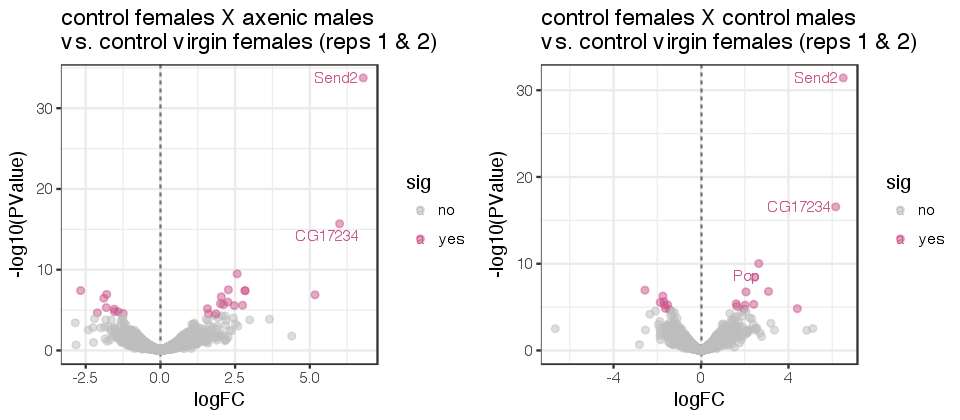

In [49]:
options(repr.plot.width = 8, repr.plot.height = 3.5)
# pdf("Figures/mated_control_female_contrast_reps.1.2.pdf", width = 8, height = 3.5)
plot_grid(CA.v.CO_reps.1.2_contrasts_volcano.gg, CC.v.CO_reps.1.2_contrasts_volcano.gg, ncol = 2)
# dev.off()

Let's make a point plot comparing the log fold-change between axenic and control females after mating to control males:

In [50]:
options(repr.plot.width = 4, repr.plot.height = 3.5)
AC.v.AO_x_CC.v.CO_reps.1.2 = diag.plot(lrt.AC.v.AO_reps.1.2.table, lrt.CC.v.CO_reps.1.2.table)
AA.v.AO_x_CA.v.CO_reps.1.2 = diag.plot(lrt.AA.v.AO_reps.1.2.table, lrt.CA.v.CO_reps.1.2.table)
AA.v.AO_x_AC.v.AO_reps.1.2 = diag.plot(lrt.AA.v.AO_reps.1.2.table, lrt.AC.v.AO_reps.1.2.table)
CC.v.CO_x_CA.v.CO_reps.1.2 = diag.plot(lrt.CC.v.CO_reps.1.2.table, lrt.CA.v.CO_reps.1.2.table)

Now output all these plots:

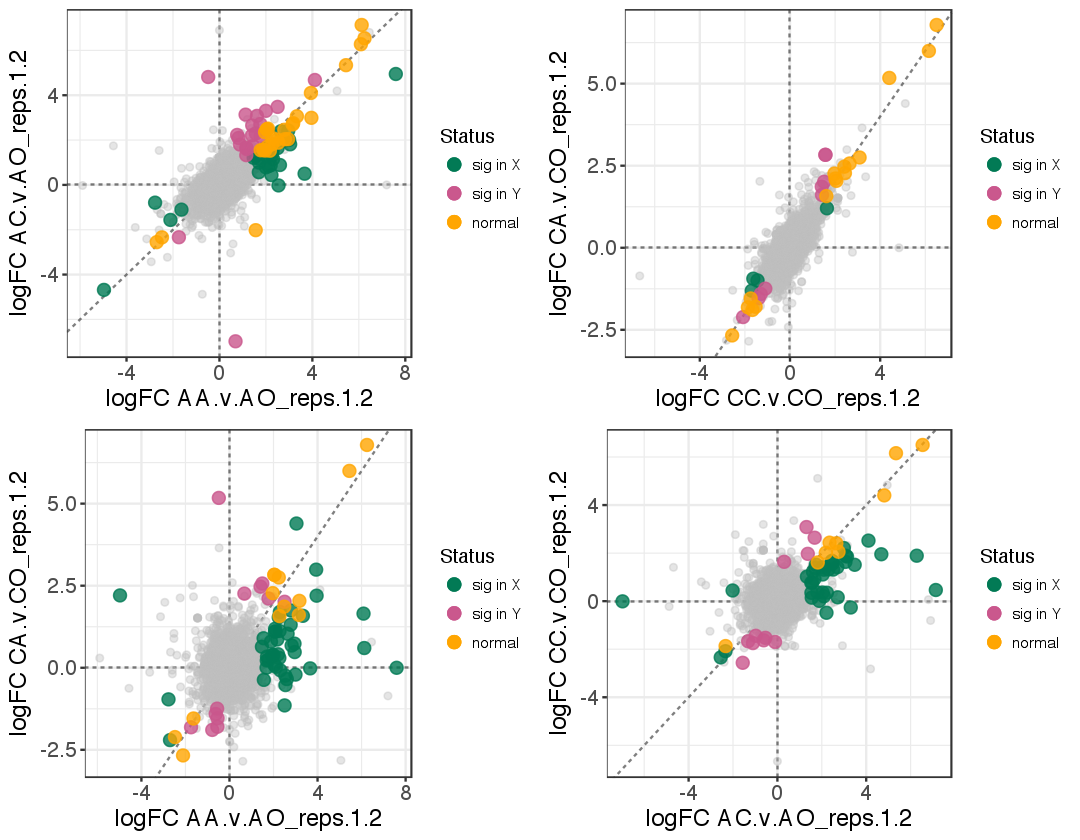

In [51]:
options(repr.plot.width = 9, repr.plot.height = 7)
# pdf("Figures/logFC_pointPlots_reps.1.2.pdf", width = 9, height = 7)
plot_grid(AA.v.AO_x_AC.v.AO_reps.1.2, CC.v.CO_x_CA.v.CO_reps.1.2, AA.v.AO_x_CA.v.CO_reps.1.2, AC.v.AO_x_CC.v.CO_reps.1.2, ncol = 2)
# dev.off()

### Re-analysis with only replicates 3 and 4:

First, filter out genes with very low expression from the counts matrix. We'll use a minimum cutoff of 1 CPM in at least 4 samples:

In [52]:
counts_bt2_reps.3.4 = select(counts_bt2, matches("3|4"))
cpm_bt2_reps.3.4 <- cpm(counts_bt2_reps.3.4)
thresh_bt2_reps.3.4 <- cpm_bt2_reps.3.4 > 1
keep_bt2_reps.3.4 <- rowSums(thresh_bt2_reps.3.4) >= 2
countsKeep_bt2_reps.3.4 <- counts_bt2_reps.3.4[keep_bt2_reps.3.4,]
# countsKeep_bt2 <- subset(countsKeep_bt2, rownames(countsKeep_bt2) %!in% wierd_genes)
dim(countsKeep_bt2_reps.3.4)

[1] 7608   12

Now define the groupings by sample and set up the design matrix:

In [53]:
sampleInfo_reps.3.4 = filter(sampleInfo, Handler == "Yasir")
groups_reps.3.4 = factor(sampleInfo_reps.3.4$Sample)
design_reps.3.4 = model.matrix( ~ 0 + groups_reps.3.4)
colnames(design_reps.3.4) <- levels(groups_reps.3.4)
rownames(design_reps.3.4) <- sampleInfo_reps.3.4$Replicate

Create the DGElist object and GLM fit:

In [54]:
dgeList_reps.3.4 <- DGEList(counts = countsKeep_bt2_reps.3.4, group = groups_reps.3.4)
dgeList_reps.3.4 <- calcNormFactors(dgeList_reps.3.4)
dgeList_reps.3.4 <- estimateCommonDisp(dgeList_reps.3.4)
dgeList_reps.3.4 <- estimateTagwiseDisp(dgeList_reps.3.4)
dgeList_reps.3.4_fit <- glmFit(dgeList_reps.3.4, design_reps.3.4)
summary(dgeList_reps.3.4$tagwise.dispersion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.03862 0.04951 0.05900 0.07555 0.08071 1.24800 

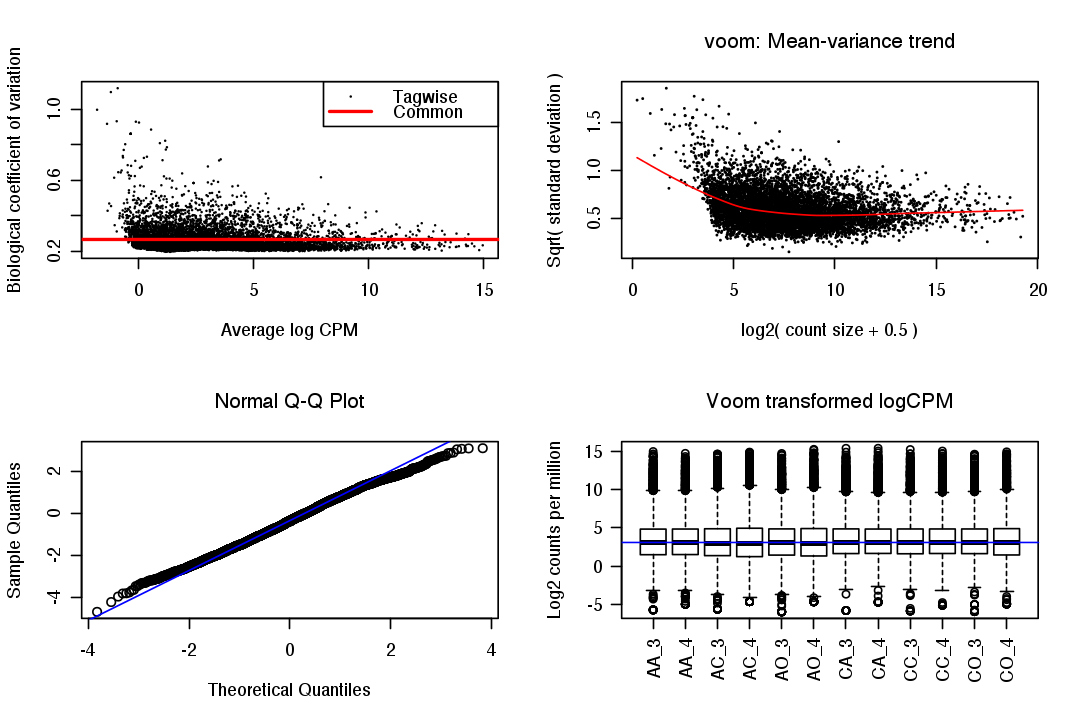

In [55]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList_reps.3.4)
# mean-variance trend
virgin.voom = voom(dgeList_reps.3.4, design_reps.3.4, plot=TRUE)
# QQ-plot
g.v <- gof(dgeList_reps.3.4_fit)
z.v <- zscoreGamma(g.v$gof.statistics,shape=g.v$df/2,scale=2)
qqnorm(z.v); qqline(z.v, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(virgin.voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(virgin.voom$E),col="blue")

rm(virgin.voom, g.v, z.v)

Generate a correlation plot between replicates:

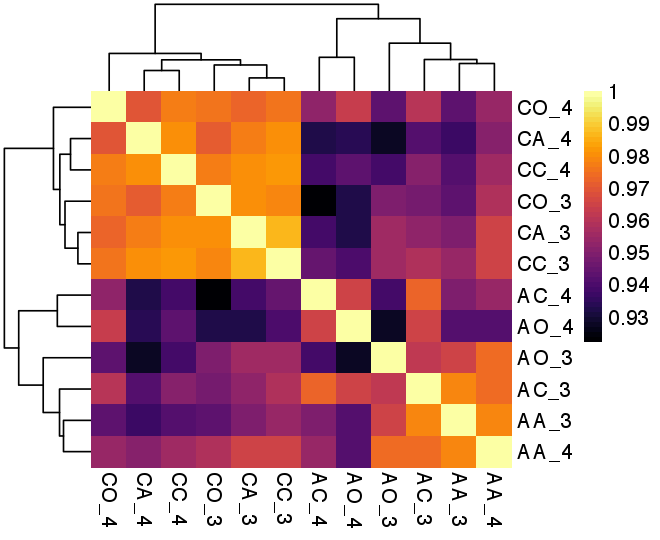

In [56]:
## Plot sample correlation
data = log2(countsKeep_bt2_reps.3.4+1)
# colnames(data) = gsub("Female_", "", colnames(data))
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')

options(repr.plot.width = 5.5, repr.plot.height = 4.5)
pheatmap(
  mat               = sample_cor,
  color             = inferno(50),
  border_color      = NA,
  show_colnames     = TRUE,
  show_rownames     = TRUE,
#   filename          = "Figures/repTract_sample_correlations.pdf",
#   width             = 6, 
#   height            = 5,
  fontsize          = 12    
)
rm(data)
rm(sample_cor)

Look at an MDS plot:

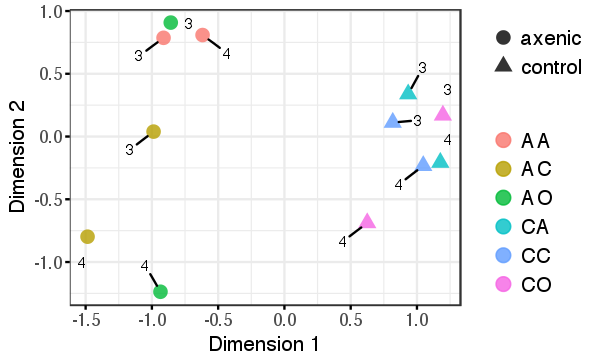

In [57]:
options(repr.plot.width = 5, repr.plot.height = 3)
c.mds.gg(dgeList_reps.3.4)

First look at the difference between the axenic and control virgin samples:

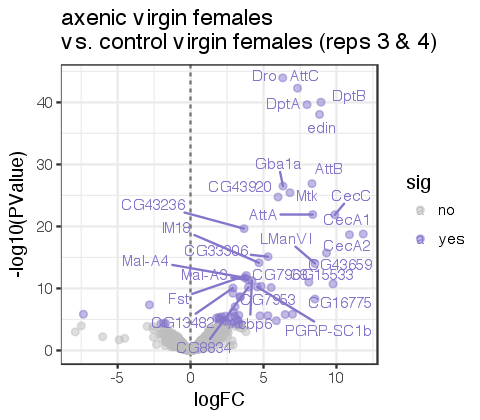

In [58]:
# run the LRT and extract the DE table
lrt.virgins_reps.3.4.table <- edge.DE(dgeList_reps.3.4_fit, virgin_contrasts)
virgins_reps.3.4_sigGenes = subset(lrt.virgins_reps.3.4.table, sig == "yes")$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
# pdf("Figures/virgin_female_contrast_reps.3.4.pdf", width = 4, height = 3.5)
(virgin_reps.3.4_contrasts_volcano.gg = edge.DE.gg(lrt.virgins_reps.3.4.table) +
                                scale_colour_manual(values = c("gray","#8675ca")) +
                                geom_text_repel(data = filter(lrt.virgins_reps.3.4.table, sig == "yes" & -log10(PValue) > 10),aes(label=gene_symbol), 
                                force = 10,
                                fontface = "bold", 
                                size = 3) +
                                labs(title = "axenic virgin females \nvs. control virgin females (reps 3 & 4)", size = 2))
# dev.off()

Now compare the mated axenic females to virgin axenic females. First, females mated to axenic males

In [59]:
# run the LRT and extract the DE table
lrt.AA.v.AO_reps.3.4.table <- edge.DE(dgeList_reps.3.4_fit, AA.v.AO_contrasts)
AA.v.AO_reps.3.4_sigGenes = subset(lrt.AA.v.AO_reps.3.4.table, sig == "yes")$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
AA.v.AO_reps.3.4_contrasts_volcano.gg = edge.DE.gg(lrt.AA.v.AO_reps.3.4.table) +
                                scale_colour_manual(values = c("gray","#007954")) +
                                geom_text_repel(data = filter(lrt.AA.v.AO_reps.3.4.table, sig == "yes" & -log10(PValue) > 10),
                                                aes(label=gene_symbol),
                                                force = 10,
                                                fontface = "bold",
                                                size = 3) +
                                labs(title = "axenic females X axenic males\nvs. axenic virgin females (reps 3 & 4)", size = 2)

... and females mated to control males

In [60]:
# run the LRT and extract the DE table
lrt.AC.v.AO_reps.3.4.table <- edge.DE(dgeList_reps.3.4_fit, AC.v.AO_contrasts)
AC.v.AO_reps.3.4_sigGenes = subset(lrt.AC.v.AO_reps.3.4.table, sig == "yes")$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
AC.v.AO_reps.3.4_contrasts_volcano.gg = edge.DE.gg(lrt.AC.v.AO_reps.3.4.table) +
                                scale_colour_manual(values = c("gray","#007954")) +
                                geom_text_repel(data = filter(lrt.AC.v.AO_reps.3.4.table, sig == "yes" & -log10(PValue) > 10),
                                                aes(label=gene_symbol),
                                                force = 10,
                                                fontface = "bold",
                                                size = 3) +
                                labs(title = "axenic females X control males\nvs. axenic virgin females (reps 3 & 4)", size = 2)

Show those volcano plots:

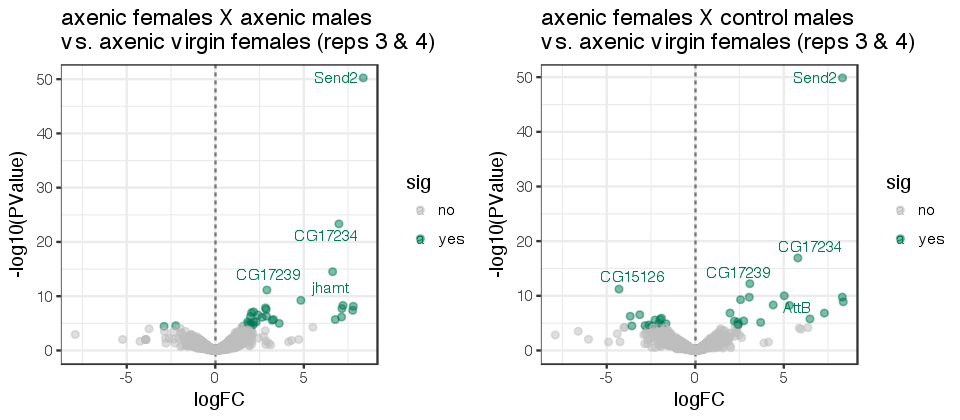

In [61]:
options(repr.plot.width = 8, repr.plot.height = 3.5)
# pdf("Figures/mated_axenic_female_contrast_reps.3.4.pdf", width = 8, height = 3.5)
plot_grid(AA.v.AO_reps.3.4_contrasts_volcano.gg, AC.v.AO_reps.3.4_contrasts_volcano.gg, ncol = 2)
# dev.off()

Now let's look at the control females.

First, females mated to axenic males

In [62]:
# run the LRT and extract the DE table
lrt.CA.v.CO_reps.3.4.table <- edge.DE(dgeList_reps.3.4_fit, CA.v.CO_contrasts)
CA.v.CO_reps.3.4_sigGenes = subset(lrt.CA.v.CO_reps.3.4.table, sig == "yes")$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
CA.v.CO_reps.3.4_contrasts_volcano.gg = edge.DE.gg(lrt.CA.v.CO_reps.3.4.table) +
                                scale_colour_manual(values = c("gray","#c9578c")) +
                                geom_text_repel(data = filter(lrt.CA.v.CO_reps.3.4.table, sig == "yes"),
                                                aes(label=gene_symbol),
                                                force = 10,
                                                fontface = "bold",
                                                size = 3) +
                                labs(title = "control females X axenic males\nvs. control virgin females (reps 3 & 4)", size = 2)

... and females mated to control males

In [63]:
# run the LRT and extract the DE table
lrt.CC.v.CO_reps.3.4.table <- edge.DE(dgeList_reps.3.4_fit, CC.v.CO_contrasts)
CC.v.CO_reps.3.4_sigGenes = subset(lrt.CC.v.CO_reps.3.4.table, sig == "yes")$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
CC.v.CO_reps.3.4_contrasts_volcano.gg = edge.DE.gg(lrt.CC.v.CO_reps.3.4.table) +
                                scale_colour_manual(values = c("gray","#c9578c")) +
                                geom_text_repel(data = filter(lrt.CC.v.CO_reps.3.4.table, sig == "yes"),
                                                aes(label=gene_symbol),
                                                force = 10,
                                                fontface = "bold",
                                                size = 3) +
                                labs(title = "control females X control males\nvs. control virgin females (reps 3 & 4)", size = 2)

Show those volcano plots:

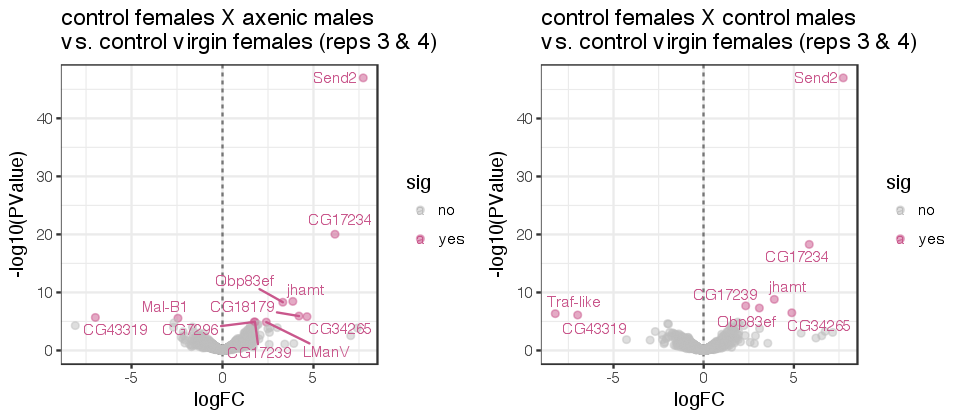

In [64]:
options(repr.plot.width = 8, repr.plot.height = 3.5)
# pdf("Figures/mated_control_female_contrast_reps.3.4.pdf", width = 8, height = 3.5)
plot_grid(CA.v.CO_reps.3.4_contrasts_volcano.gg, CC.v.CO_reps.3.4_contrasts_volcano.gg, ncol = 2)
# dev.off()

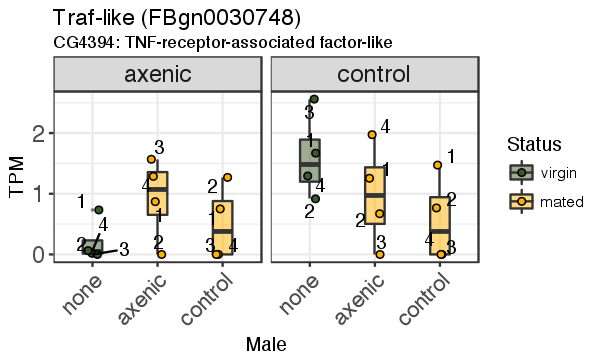

In [65]:
options(repr.plot.width = 5, repr.plot.height = 3)
geneBoxPlot("Traf-like", show_reps = T)

Let's make a point plot comparing the log fold-change between axenic and control females after mating to control males:

In [66]:
options(repr.plot.width = 4, repr.plot.height = 3.5)
AC.v.AO_x_CC.v.CO_reps.3.4 = diag.plot(lrt.AC.v.AO_reps.3.4.table, lrt.CC.v.CO_reps.3.4.table)
AA.v.AO_x_CA.v.CO_reps.3.4 = diag.plot(lrt.AA.v.AO_reps.3.4.table, lrt.CA.v.CO_reps.3.4.table)
AA.v.AO_x_AC.v.AO_reps.3.4 = diag.plot(lrt.AA.v.AO_reps.3.4.table, lrt.AC.v.AO_reps.3.4.table)
CC.v.CO_x_CA.v.CO_reps.3.4 = diag.plot(lrt.CC.v.CO_reps.3.4.table, lrt.CA.v.CO_reps.3.4.table)

Now output all these plots:

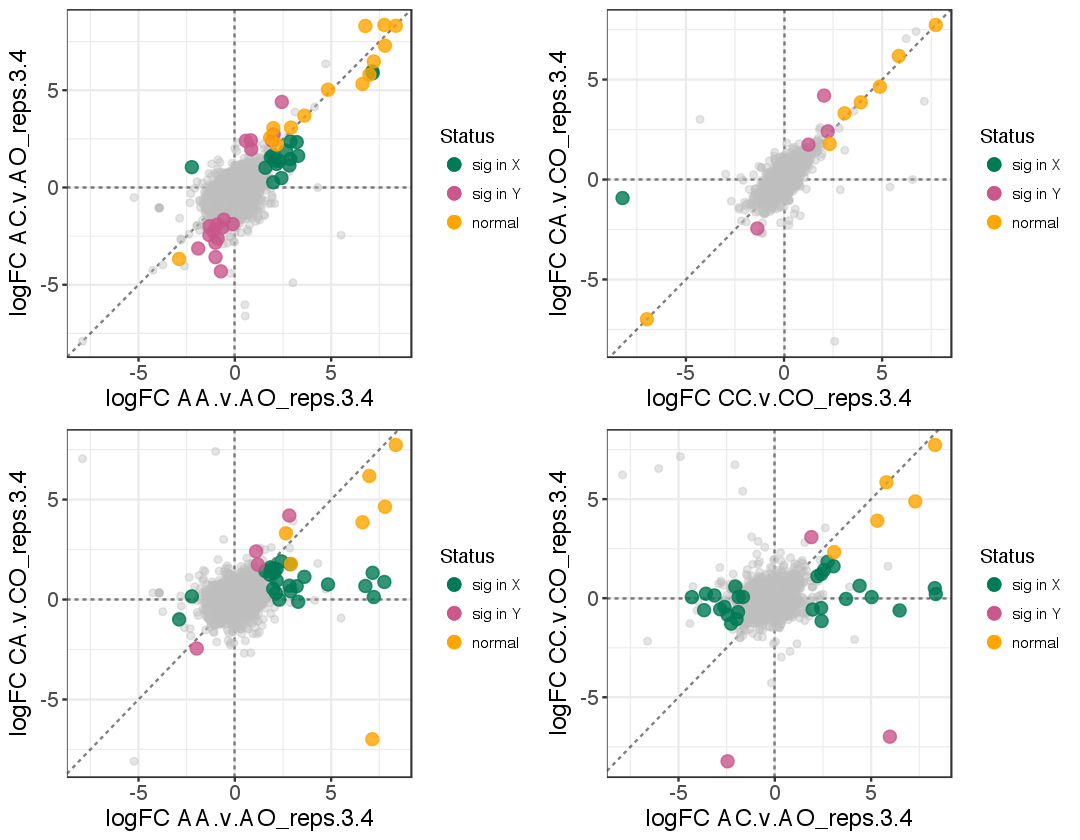

In [67]:
options(repr.plot.width = 9, repr.plot.height = 7)
# pdf("Figures/logFC_pointPlots_reps.3.4.pdf", width = 9, height = 7)
plot_grid(AA.v.AO_x_AC.v.AO_reps.3.4, CC.v.CO_x_CA.v.CO_reps.3.4, AA.v.AO_x_CA.v.CO_reps.3.4, AC.v.AO_x_CC.v.CO_reps.3.4, ncol = 2)
# dev.off()

Here's a way to look at the overlap between the different approaches:

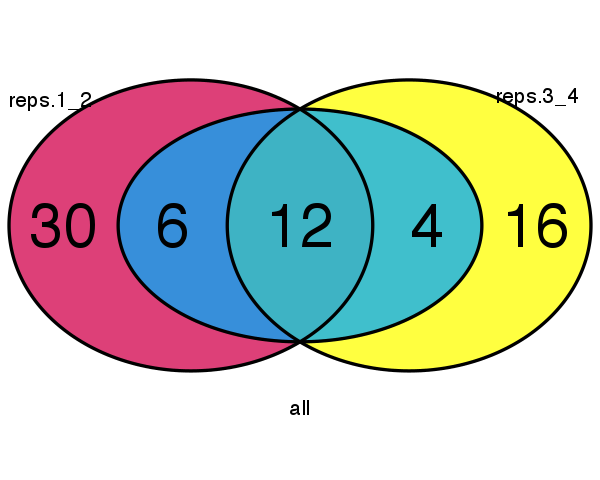

In [68]:
temp_candidates <- list(all = AC.v.AO_sigGenes, 
                        reps.1_2 = AC.v.AO_reps.1.2_sigGenes, 
                        reps.3_4 = AC.v.AO_reps.3.4_sigGenes)

temp_Vdiag<-venn.diagram(temp_candidates, NULL, fill=c("#01aafb", "#d1004b", "yellow"), alpha=c(0.75,0.75,0.75), cex = 3, cat.fontface= 6, cat.cex = 1, resolution = 100, )

options(repr.plot.width = 5, repr.plot.height = 4)
grid.arrange(gTree(children=temp_Vdiag))
rm(temp_candidates, temp_Vdiag)